# Clustering models

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel,LsiModel,LdaMulticore,TfidfModel
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gsdmm import MovieGroupProcess
from sklearn.decomposition import PCA
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import pprint
from wordcloud import WordCloud
from plotnine import *
import plotnine as p9
import patchworklib as pw 
pd.options.plotting.backend = "plotly"

<Figure size 100x100 with 0 Axes>

In [2]:
df_main = pd.read_csv('main_df.csv')

In [3]:
df_main.head()

,Unnamed: 0,id,type,domain,scraped_at,url,authors,title,content,word_count,char_count,word_density,polarity,subjectivity,nouns,noun_chunks,entities,lemmas
0,0,7025856,political,dailykos.com,2017-11-27,https://www.dailykos.com/stories/2013/10/17/12...,"Backgroundurl Avatar_Large, Nickname, Joined, ...",Classic Bachmann: Default avoided because Repu...,"Pssst, Michele, you just called yourself not a...",212,982,0.215666,0.154630,0.662191,"['adult', 'Pssst', 'adult', 'dice', 'adults', ...","['Michele', 'Republicans', 'default', 'intense...","['Pssst, Michele', 'Michele', 'Republicans', ""...","['Pssst', 'Michele', 'call', 'adult', 'pssst',..."
1,1,1966549,political,breitbart.com,2017-11-10,http://www.breitbart.com/jerusalem/2016/06/01/...,"Aaron Klein, Ali Waked","EXCLUSIVE: Hamas, Hezbollah Recruiting Fatah M...",TEL AVIV – The Israel Defense Forces on Monday...,367,1972,0.186011,0.046875,0.414167,"['city', 'refugee', 'camps', 'suspicion', 'pos...","['TEL AVIV', 'Monday', ' Palestinians', 'Nablu...","['TEL AVIV', 'The Israel Defense Forces', 'Pal...","['TEL', 'AVIV', 'Israel', 'Defense', 'Forces',..."
2,2,2628942,political,alternet.org,2017-11-13,https://www.alternet.org/environment/revealed-...,NaN,Revealed: FBI Terrorism Taskforce Investigatin...,Revealed: FBI Terrorism Taskforce Investigatin...,904,4889,0.184867,-0.039660,0.413462,"['leaders', 'movement', 'fear', 'terrorists', ...","['FBI Terrorism Taskforce', 'Standing Rock Act...","['FBI Terrorism Taskforce Investigating', 'Peg...","['reveal', 'FBI', 'Terrorism', 'Taskforce', 'i..."
3,3,3382763,political,dailykos.com,2017-11-18,https://www.dailykos.com/stories/2006/9/11/245...,"Backgroundurl Avatar_Large, Nickname, Joined, ...",What's Condi Doing Today?,The Halifax Peace Coalition questioned the mot...,242,1221,0.198036,0.205208,0.407813,"['motivation', 'visit', 'relations', 'campaign...","['support', 'Afghanistan', 'Canadian troops', ...","['The Halifax Peace Coalition', 'Rice', 'Afgha...","['Halifax', 'Peace', 'Coalition', 'question', ..."
4,4,2034907,political,nationalreview.com,2017-11-10,http://www.nationalreview.com/corner/81541,Michael Ledeen,National Review,"Well, it’s very important, actually, because i...",337,1640,0.205363,0.127504,0.521075,"['hands', 'yellowcake', 'asset', 'president', ...","['Saddam', 'yellowcake', 'Niger', 'Seymour Her...","['Brits', 'Saddam', 'Niger', 'CIA', 'Seymour H...","['important', 'actually', 'explain', 'Brits', ..."


# TF-IDF + k-means

In [4]:
def make_string_list(df_main, column_name):
    """
    Converts a column of a dataframe into a list of list of strings.

    Args:
    - df_main:  the main dataframe
    - column_name: the name of the column to convert

    Returns:
    - nouns_list:  a list of list of strings
    """
    str_lists = [df_main[column_name].tolist()[i][1:-1].split(',') for i in range(len(df_main))]
    nouns_list = []
    for i in range(len(str_lists)):
        nouns_list.append(np.array([x.strip()[1:-1] for x in str_lists[i]]))
    return nouns_list


def tfidf_vectorizer(nouns_list):
    """
    Applies TF-IDF vectorization to a list of strings.

    Args:
    - nouns_list: list of strings

    Returns:
    - X_tfidf:  the TF-IDF representation of the input data
    """
    joined_strings = [' '.join(sublist) for sublist in nouns_list]
    vectorizer = CountVectorizer(max_features=100)
    X = vectorizer.fit_transform(joined_strings)
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X)
    return X_tfidf

In [5]:
lemmas_list = make_string_list(df_main,'lemmas')
X_tfidf_lemmas = tfidf_vectorizer(lemmas_list)

noun_chunks_list = make_string_list(df_main,'noun_chunks')
X_tfidf_chunks = tfidf_vectorizer(noun_chunks_list)


## Choose the number of clusters

In [6]:
def plot_metrics(data, max_clusters):
    """
    Plot the elbow method, silhouette scores, and Calinski-Harabasz index for different numbers of clusters.

    Args:
    - data: the input data
    - max_clusters: the maximum number of clusters to consider


    """
    silhouette_scores = []
    distortions = []
    ch_indexes = []
    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++',n_init=10, random_state=42)
        kmeans.fit(data)
        cluster_labels = kmeans.labels_
        distortions.append(kmeans.inertia_)
        if issparse(data):
            data = data.toarray()
        sscore = silhouette_score(data, cluster_labels)
        silhouette_scores.append(sscore)
        chindex = calinski_harabasz_score(data, cluster_labels)
        ch_indexes.append(chindex)
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    axs[0].plot(range(2, max_clusters + 1), distortions, marker='o')
    axs[0].set_title('Elbow Method')
    axs[0].set_xlabel('Number of clusters')
    axs[0].set_ylabel('Total within-cluster sum of squares')
    axs[0].set_xticks(np.arange(2, max_clusters + 1))
    axs[1].plot(range(2, max_clusters+1), silhouette_scores, marker='o')
    axs[1].set_xlabel('Number of Clusters')
    axs[1].set_ylabel('Silhouette Score')
    axs[1].set_title('Silhouette Score')
    axs[1].set_xticks(np.arange(2, max_clusters + 1))
    axs[2].plot(range(2, max_clusters+1), ch_indexes, marker='o')
    axs[2].set_xlabel('Number of Clusters')
    axs[2].set_ylabel('Calinski-Harabasz Index')
    axs[2].set_title('Calinski-Harabasz Index')
    axs[2].set_xticks(np.arange(2, max_clusters + 1))
    plt.show()
    plt.show()

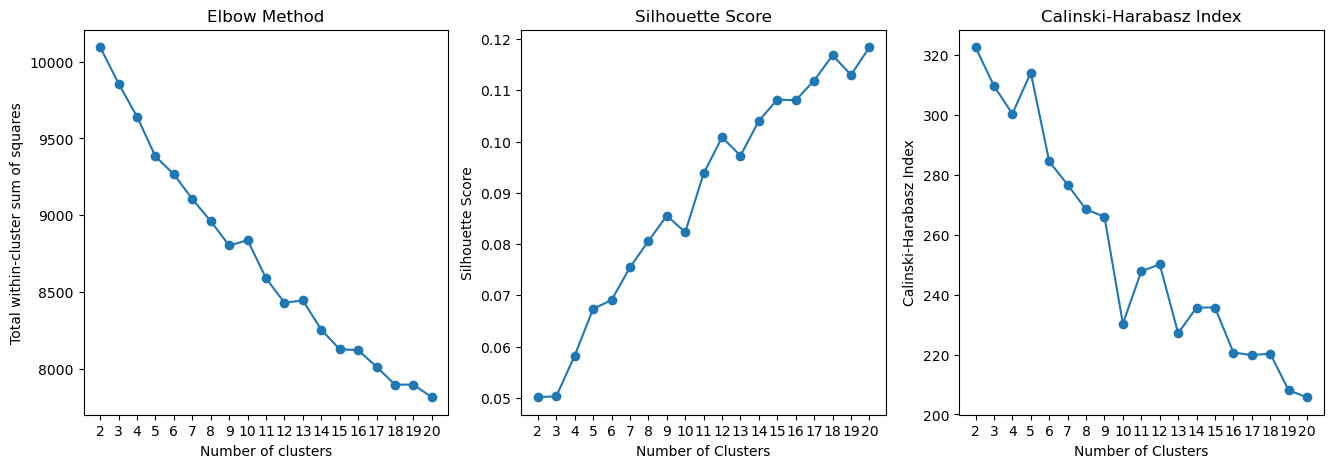

In [ ]:
plot_metrics(X_tfidf_chunks, max_clusters=20)

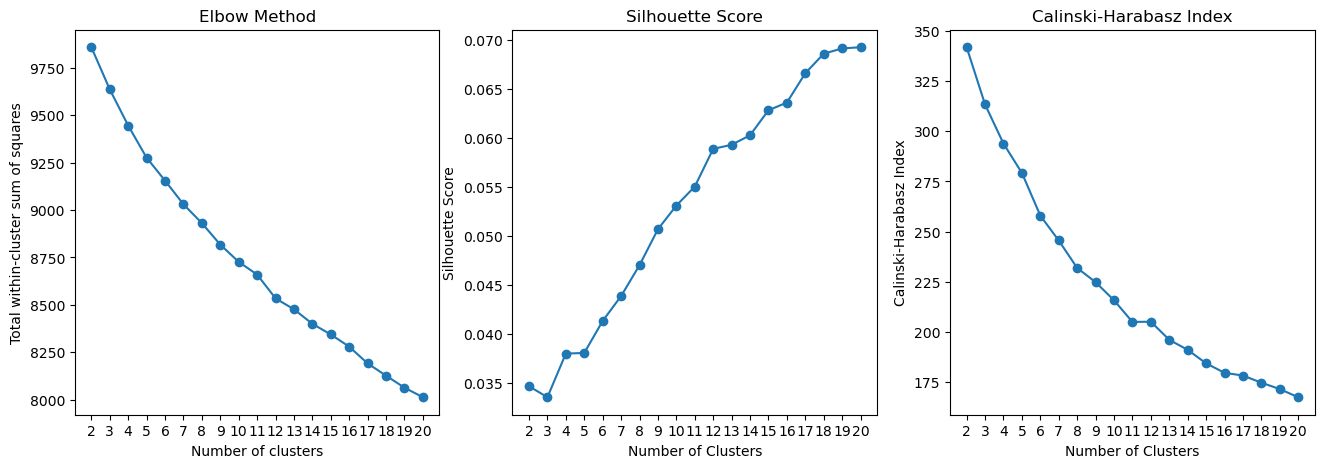

In [ ]:
plot_metrics(X_tfidf_lemmas, max_clusters=20)

## Evaluation

In [6]:
def kmeans_clustering(X, num_clusters):
    """
    Perform k-means clustering on the input data.

    Args:
    - X: the input data
    - num_clusters: the number of clusters to create

    Returns:
    - labels: the cluster labels assigned to each data point
    """
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10, init='k-means++')
    kmeans.fit(X)
    return kmeans.labels_

In [7]:
labels_tf_idf_chunks = kmeans_clustering(X_tfidf_chunks, 5)
labels_tf_idf_lemmas = kmeans_clustering(X_tfidf_lemmas, 4)

In [ ]:
print('Silhouette Score: {}'.format(silhouette_score(X_tfidf_lemmas.toarray() , labels_tf_idf_lemmas)))
print('Calinski Harabasz Score: {}'.format(calinski_harabasz_score(X_tfidf_lemmas.toarray() , labels_tf_idf_lemmas)))

Silhouette Score: 0.03798813210205043
Calinski Harabasz Score: 293.8629144253833


In [ ]:
print('Silhouette Score: {}'.format(silhouette_score(X_tfidf_chunks.toarray() , labels_tf_idf_chunks)))
print('Calinski Harabasz Score: {}'.format(calinski_harabasz_score(X_tfidf_chunks.toarray() , labels_tf_idf_chunks)))

Silhouette Score: 0.0673791622176425
Calinski Harabasz Score: 314.09142018464036


## Visualization of clusters

In [ ]:
def subdim_plot(data, labels):
    """
    Plot the data in a lower-dimensional space using PCA and t-SNE.

    Args:
    - data: the input data
    - labels: the labels assigned to each data point

    """
    pca = PCA(n_components=2)
    pca.fit(data)
    pca_data = pca.transform(data)
    
    tsne = TSNE(n_components=2)
    tsne_data = tsne.fit_transform(data)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    axs[0].scatter(pca_data[:, 0], pca_data[:, 1], c=labels)
    axs[0].set_xlabel('X1')
    axs[0].set_ylabel('X2')
    axs[0].set_title('PCA Plot')
    
    axs[1].scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels)
    axs[1].set_xlabel('X1')
    axs[1].set_ylabel('X2')
    axs[1].set_title('t-SNE Plot')
    
    plt.tight_layout()
    plt.show()


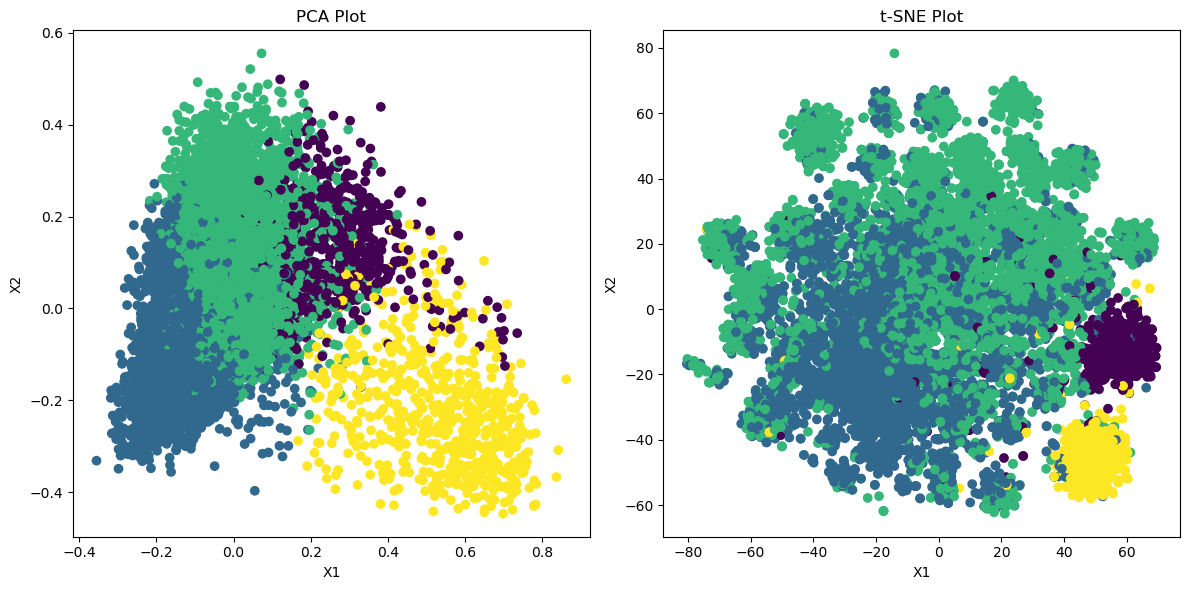

In [ ]:
subdim_plot(X_tfidf_lemmas.toarray(), labels_tf_idf_lemmas)

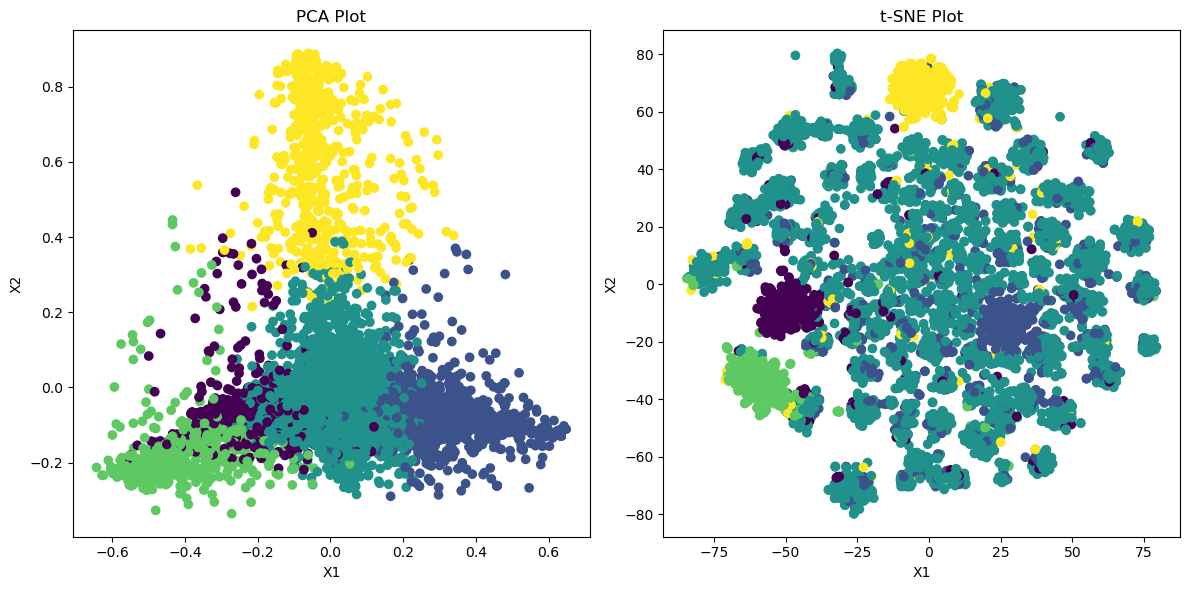

In [ ]:
subdim_plot(X_tfidf_chunks.toarray(), labels_tf_idf_chunks)

In [8]:
def save_clustering_results(df_main, labels, filename):
    df = pd.DataFrame({'id': df_main['id'], 'cluster': labels})
    df.to_csv(filename, index=False)

In [ ]:
save_clustering_results(df_main, labels_tf_idf_lemmas, 'tfidf4.csv')
save_clustering_results(df_main, labels_tf_idf_chunks, 'tfidf5_nouns.csv')

# Doc2Vec + k-means

In [8]:
def doc2vec_vecotrization(str_list):
    """
    Perform Doc2Vec vectorization on a list of strings.

    Args:
    - str_list: the list of strings to be vectorized

    Returns:
    - X_doc2vec: the Doc2Vec vectors of the input strings
    """
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(str_list)]
    doc2vec_model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)
    doc2vec_model.build_vocab(documents)
    doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    document_vectors = [doc2vec_model.infer_vector(doc) for doc in str_list]
    X_doc2vec= np.array(document_vectors)
    return X_doc2vec


In [9]:
X_doc2vec_lemmas = doc2vec_vecotrization(lemmas_list)
X_doc2vec_chunks = doc2vec_vecotrization(noun_chunks_list)

## Choose the number of clusters

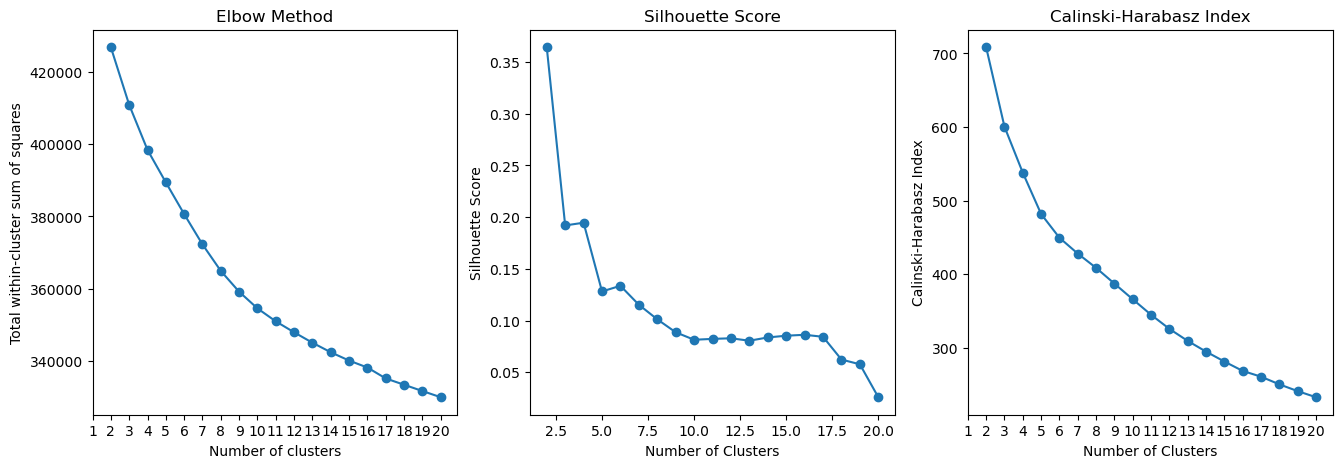

In [ ]:
plot_metrics(X_doc2vec_lemmas , max_clusters=20)

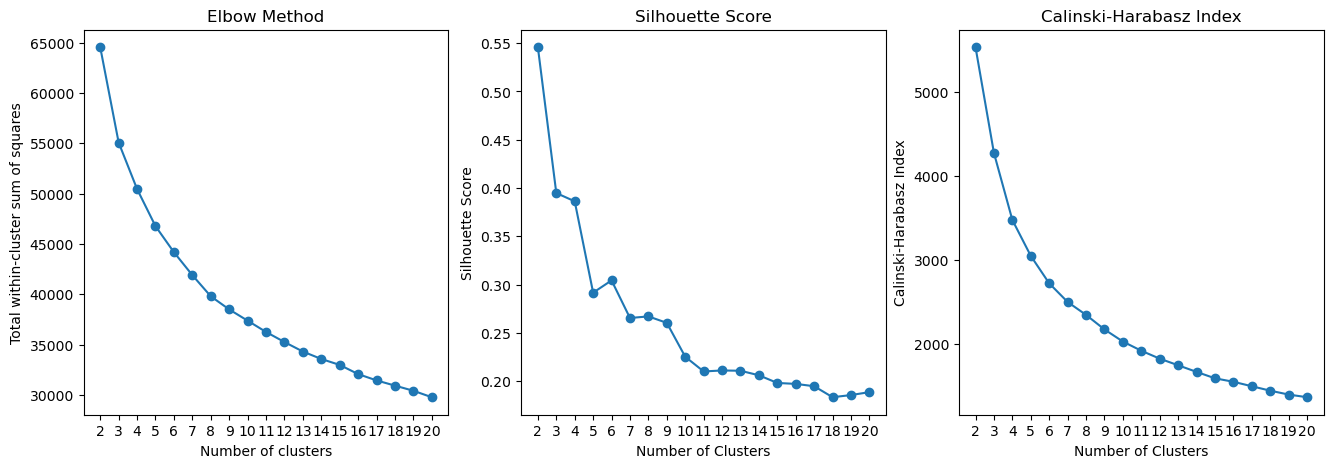

In [ ]:
plot_metrics(X_doc2vec_chunks , max_clusters=20)

## Evaluation

In [10]:
labels_doc2vec_lemmas = kmeans_clustering(X_doc2vec_lemmas, 6)
labels_doc2vec_chunks = kmeans_clustering(X_doc2vec_chunks, 4)

In [ ]:
print('Silhouette Score: {}'.format(silhouette_score(X_doc2vec_lemmas, labels_doc2vec_lemmas)))
print('Calinski Harabasz Score: {}'.format(calinski_harabasz_score(X_doc2vec_lemmas,labels_doc2vec_lemmas)))

Silhouette Score: 0.13361920416355133
Calinski Harabasz Score: 449.6207504338645


In [ ]:
print('Silhouette Score: {}'.format(silhouette_score(X_doc2vec_chunks, labels_doc2vec_chunks)))
print('Calinski Harabasz Score: {}'.format(calinski_harabasz_score(X_doc2vec_chunks,labels_doc2vec_chunks)))

Silhouette Score: 0.38618338108062744
Calinski Harabasz Score: 3473.236819471295


## Visualization of clusters

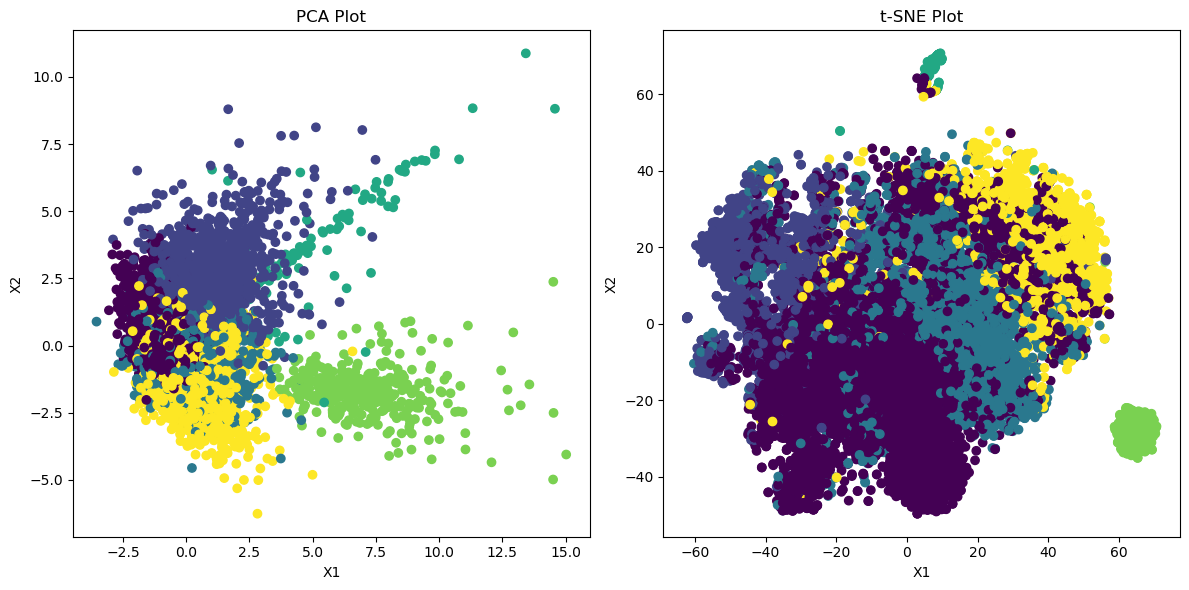

In [ ]:
subdim_plot(X_doc2vec_lemmas, labels_doc2vec_lemmas)

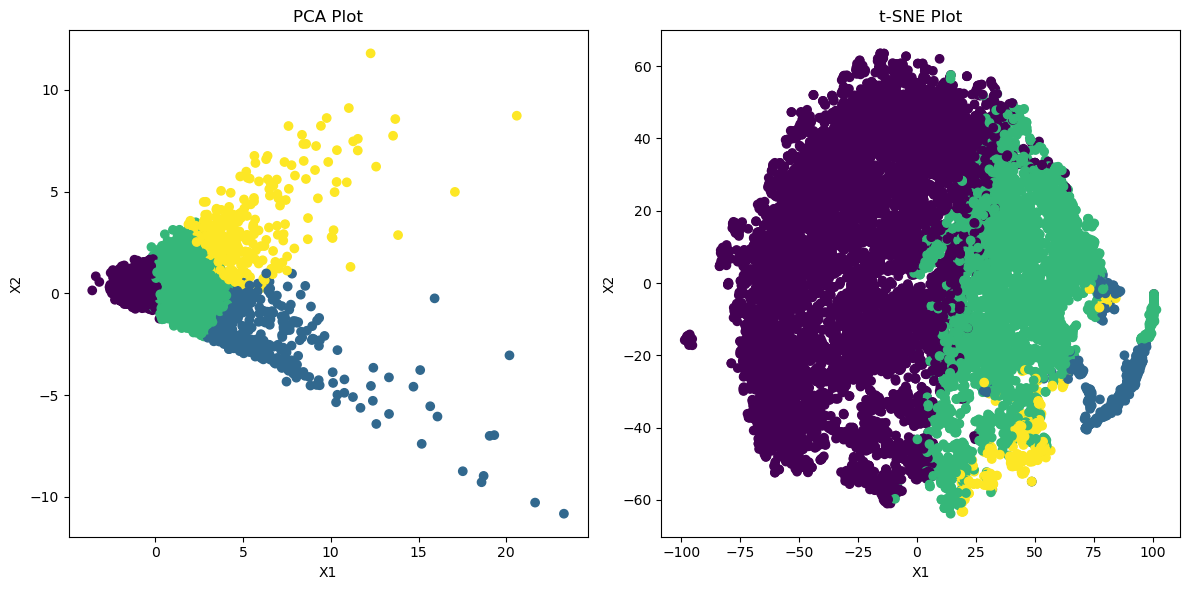

In [ ]:
subdim_plot(X_doc2vec_chunks, labels_doc2vec_chunks)

In [ ]:
save_clustering_results(df_main, labels_doc2vec_lemmas, 'doc2vec6.csv')
save_clustering_results(df_main, labels_doc2vec_chunks, 'doc2vec4_nouns.csv')

# LDA

In [11]:
def get_corpus_dict(str_list, tfidf=False):
    """
    Get the dictionary and corpus for a nested list of strings

    Args:
    - str_list: the nested list of strings
    - tfidf: a boolean indicating whether to apply TF-IDF transformation (default: False)

    Returns:
    - dictionary: the dictionary of the strings
    - corpus: the corpus representation of the strings
    """
    dictionary = corpora.Dictionary(str_list)
    if tfidf:
        corpus = [dictionary.doc2bow(text) for text in str_list]
        tfidf = TfidfModel(corpus)
        corpus = tfidf[corpus]
    else:
        corpus = [dictionary.doc2bow(text) for text in str_list]
    return dictionary, corpus

In [13]:
def plot_lda_metrics(str_list,dictionary,corpus):
    """
    Plot the coherence score, silhouette score, and Calinski-Harabasz index for different numbers of topics in LDA.

    Args:
    - str_list: the nested list of strings
    - dictionary: the dictionary of the strings
    - corpus: the corpus representation of the strings

    """
    coherence_values = []
    silhouette_scores = []
    ch_indexes = []
    model_list = []
    iters = range(2,20)
    for num_topics in iters:
        model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        random_state=42)
        model_list.append(model)
        coherencemodel =  gensim.models.CoherenceModel(model=model, texts=str_list, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        doc_topics = model.get_document_topics(corpus)
        num_docs = len(doc_topics)
        doc_topics_csr = gensim.matutils.corpus2csc(doc_topics)
        X_lda = doc_topics_csr.T.toarray()
        major_topic = [np.argmax(arr) for arr in X_lda]
        labels_lda = major_topic
        silhouette_scores.append(silhouette_score(X_lda, labels_lda))
        ch_indexes.append(calinski_harabasz_score(X_lda, labels_lda))

    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    axs[0].plot(iters, coherence_values, marker='o')
    axs[0].set_xlabel("Num Topics")
    axs[0].set_ylabel("Coherence score")
    axs[0].set_title("Coherence Score")
    axs[0].set_xticks(list(range(2,20)))


    axs[1].plot(iters, silhouette_scores, marker='o')
    axs[1].set_xlabel("Num Topics")
    axs[1].set_ylabel("Silhouette Score")
    axs[1].set_title("Silhouette Score")
    axs[1].set_xticks(list(range(2,20)))

    axs[2].plot(iters, ch_indexes, marker='o')
    axs[2].set_xlabel("Num Topics")
    axs[2].set_ylabel("Calinski-Harabasz Index")
    axs[2].set_title("Calinski-Harabasz Index")
    axs[2].set_xticks(list(range(2,20)))

    plt.tight_layout()
    plt.show()


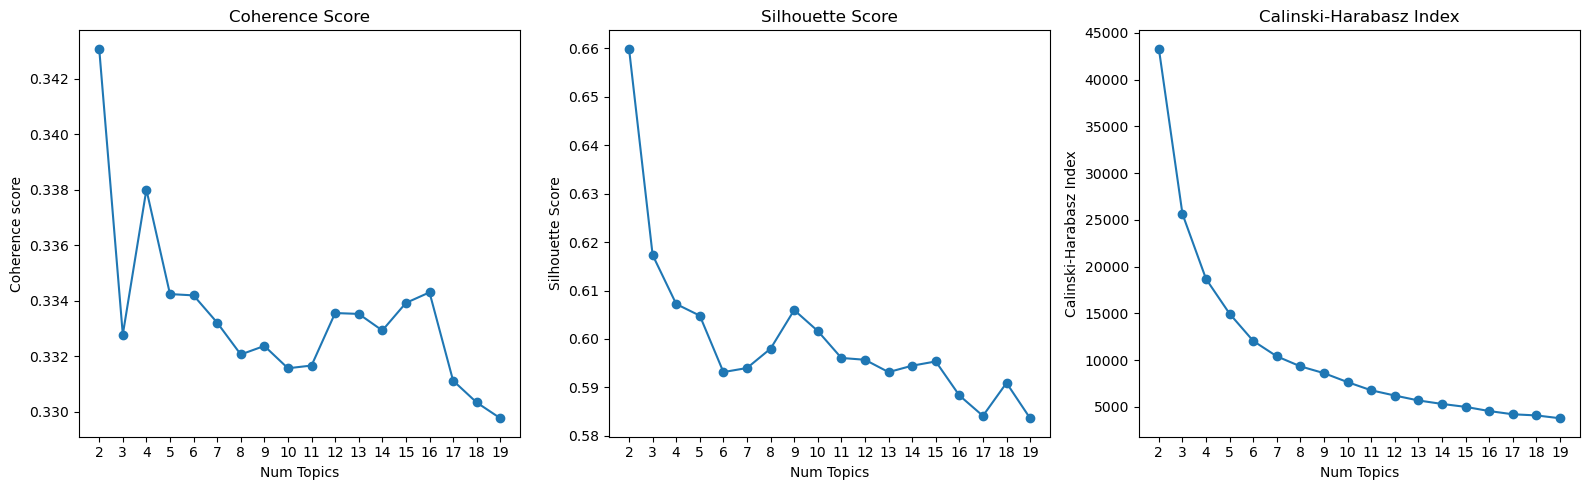

In [ ]:
dict_lemmas,corpus_lemmas = get_corpus_dict(lemmas_list,tfidf=False)
plot_lda_metrics(lemmas_list,dict_lemmas,corpus_lemmas)

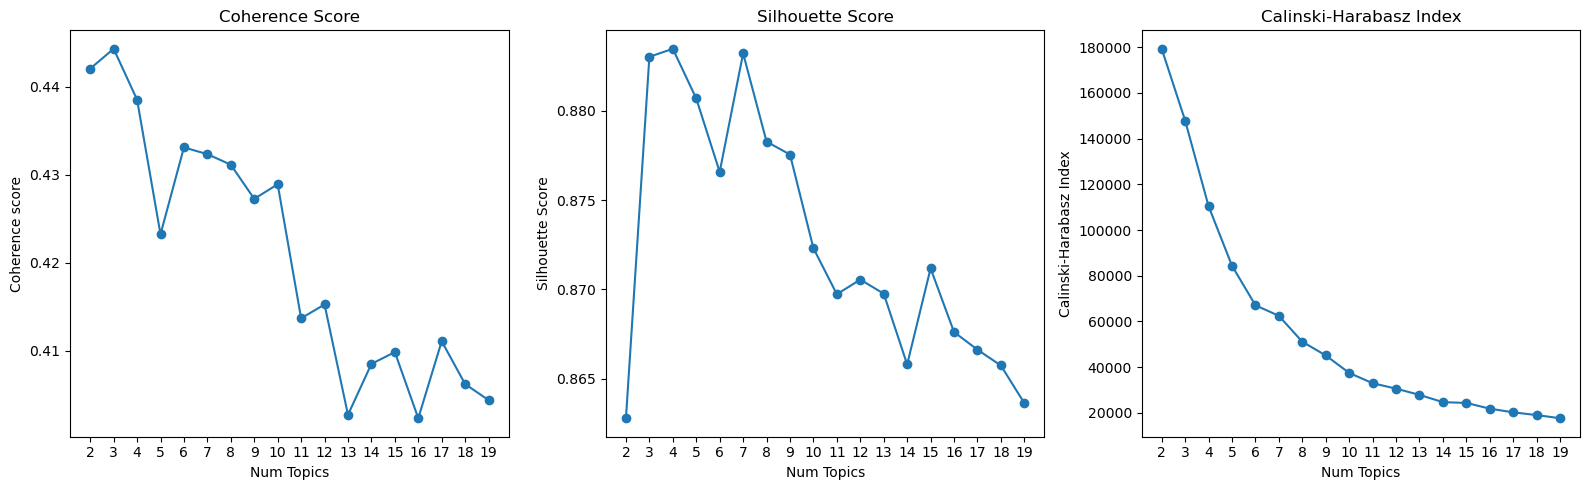

In [ ]:
dict_chunks,corpus_chunks = get_corpus_dict(noun_chunks_list,tfidf=False)
plot_lda_metrics(noun_chunks_list,dict_chunks,corpus_chunks)

## Evaluation

In [14]:
def evaluate_lda(num_topics, corpus, dictionary):
    """
    Evaluate an LDA model by calculating perplexity, coherence score, silhouette score, and Calinski-Harabasz score.

    Args:
    - num_topics: the number of topics in the LDA model
    - corpus: the corpus representation of the strings
    - dictionary: the dictionary of the strings

    Returns:
    - X_lda: the LDA vectors of the input strings
    - labels_lda: the cluster labels assigned to each data point based on LDA

    """
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics,
                             random_state=42)
    doc_topics = lda_model.get_document_topics(corpus)
    num_docs = len(doc_topics)
    doc_topics_csr = gensim.matutils.corpus2csc(doc_topics)
    X_lda = doc_topics_csr.T.toarray()
    major_topic = [np.argmax(arr) for arr in X_lda]
    labels_lda = major_topic
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=lemmas_list, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'Perplexity: {lda_model.log_perplexity(corpus)}')  
    print(f"Coherence score: {coherence_lda}")
    print('Silhouette Score: {}'.format(silhouette_score(X_lda, labels_lda)))
    print('Calinski Harabasz Score: {}'.format(calinski_harabasz_score(X_lda, labels_lda)))
    return X_lda, labels_lda


In [15]:
X_lda_lemmas,labels_lda_lemmas = evaluate_lda(4,corpus_lemmas,dict_lemmas)

Perplexity: -9.237071809039106
Coherence score: 0.3380040459327056
Silhouette Score: 0.6072140674573903
Calinski Harabasz Score: 18670.00689155482


In [16]:
X_lda_chunks,labels_lda_chunks = evaluate_lda(4,corpus_chunks,dict_chunks)

Perplexity: -11.549801697832798
Coherence score: nan
Silhouette Score: 0.8834796836259575
Calinski Harabasz Score: 110432.09622919754


In [ ]:
save_clustering_results(df_main, labels_lda_lemmas, 'lda4.csv')
save_clustering_results(df_main, labels_lda_chunks, 'lda4_nouns.csv')

## TF-IDF + LDA

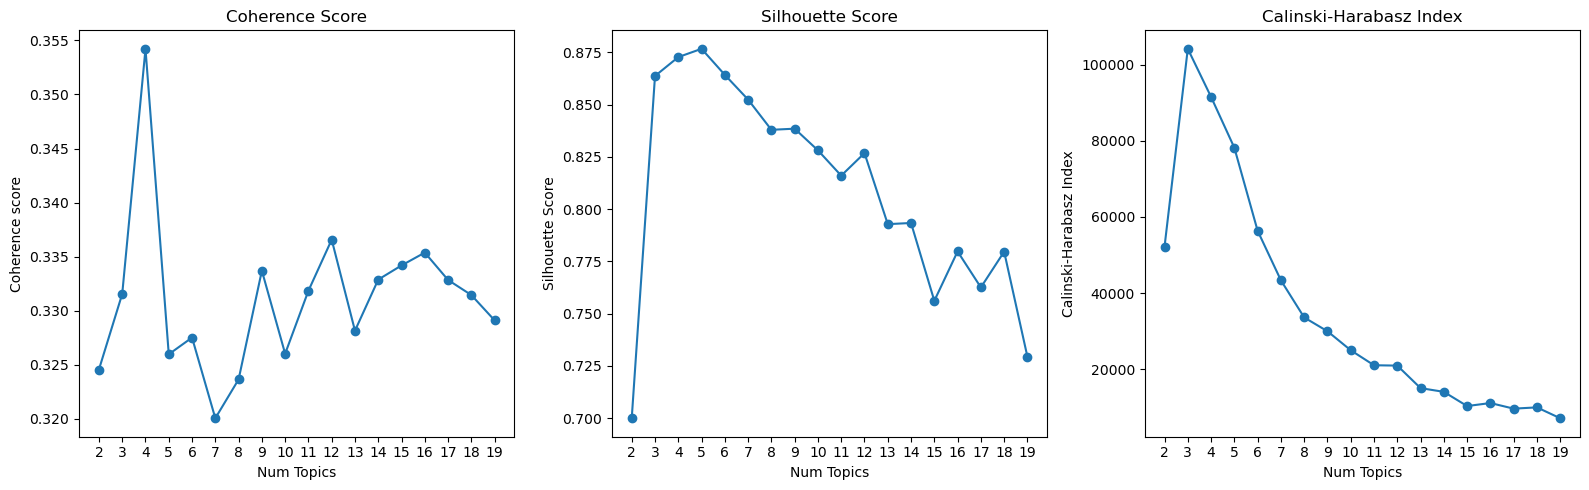

In [ ]:
dict_lemmas_tfidf,corpus_lemmas_tfidf = get_corpus_dict(lemmas_list,tfidf=True)
plot_lda_metrics(lemmas_list,dict_lemmas_tfidf,corpus_lemmas_tfidf)

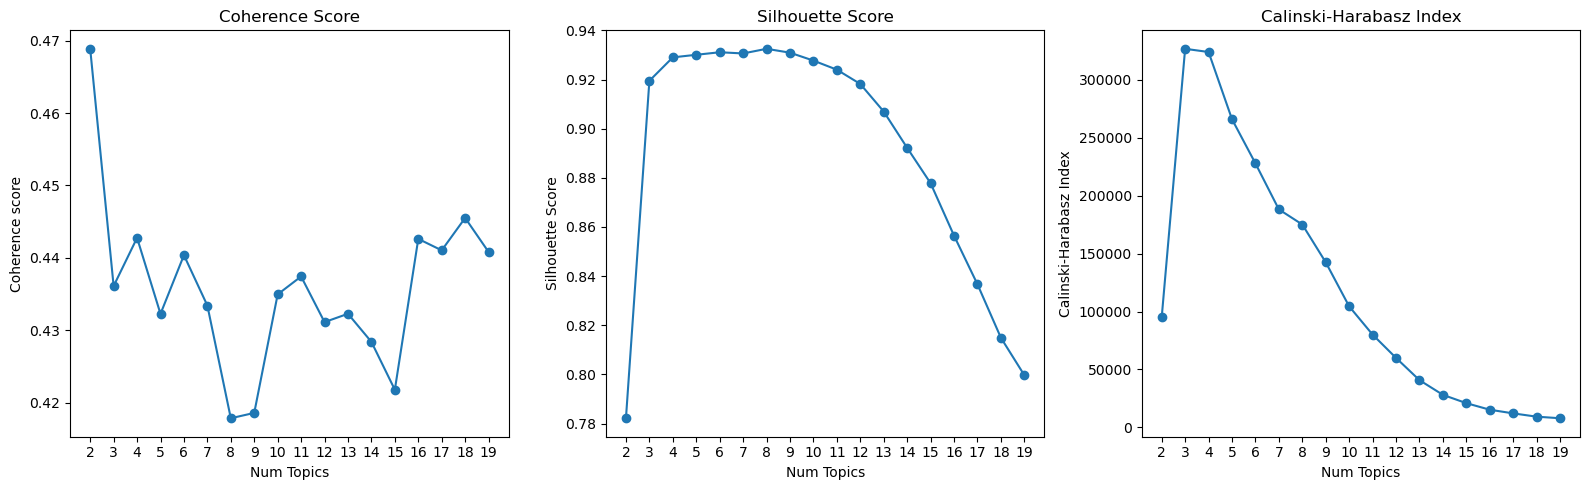

In [ ]:
dict_chunks_tfidf,corpus_chunks_tfidf = get_corpus_dict(noun_chunks_list,tfidf=True)
plot_lda_metrics(noun_chunks_list,dict_chunks_tfidf,corpus_chunks_tfidf)

# Evaluation

In [19]:
X_lda_tfidf_lemmas,labels_lda_lemmas_tfidf = evaluate_lda(4,corpus_lemmas_tfidf,dict_lemmas_tfidf)

Perplexity: -11.839318421256335
Coherence score: 0.3542242959937876
Silhouette Score: 0.8727865329790575
Calinski Harabasz Score: 91490.69166634367


In [20]:
X_lda_tfidf_chunks,labels_lda_chunks_tfidf = evaluate_lda(4,corpus_chunks_tfidf,dict_chunks_tfidf)

Perplexity: -13.975602398817294
Coherence score: nan
Silhouette Score: 0.9290509176873035
Calinski Harabasz Score: 323993.3221222616


In [ ]:
save_clustering_results(df_main, labels_lda_lemmas, 'ldatfidf4.csv')
save_clustering_results(df_main, labels_lda_chunks, 'ldtfidfa4_nouns.csv')

# LSI

In [21]:
def plot_lsi_metrics(str_list,dictionary,corpus):
    """
    Plot the coherence score, silhouette score, and Calinski-Harabasz index for different numbers of topics in LSI.

    Args:
    - str_list: the nested list of strings
    - dictionary: the dictionary of the strings
    - corpus: the corpus representation of the strings

    """
    coherence_values = []
    silhouette_scores = []
    ch_indexes = []
    model_list = []
    iters = range(2,20)
    for num_topics in iters:
        model = LsiModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics)
        model_list.append(model)
        coherencemodel =  gensim.models.CoherenceModel(model=model, texts=str_list, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        doc_topic_matrix = model[corpus] 
        X_lsi = gensim.matutils.corpus2dense(doc_topic_matrix, num_terms=num_topics).T
        silhouette_scores.append(silhouette_score(X_lsi, np.argmax(X_lsi, axis=1)))
        ch_indexes.append(calinski_harabasz_score(X_lsi, np.argmax(X_lsi, axis=1)))

    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    axs[0].plot(iters, coherence_values, marker='o')
    axs[0].set_xlabel("Num Topics")
    axs[0].set_ylabel("Coherence score")
    axs[0].set_title("Coherence Score")
    axs[0].set_xticks(list(range(2,20)))

    axs[1].plot(iters, silhouette_scores, marker='o')
    axs[1].set_xlabel("Num Topics")
    axs[1].set_ylabel("Silhouette Score")
    axs[1].set_title("Silhouette Score")
    axs[1].set_xticks(list(range(2,20)))

    axs[2].plot(iters, ch_indexes, marker='o')
    axs[2].set_xlabel("Num Topics")
    axs[2].set_ylabel("Calinski-Harabasz Index")
    axs[2].set_title("Calinski-Harabasz Index")
    axs[2].set_xticks(list(range(2,20)))

    plt.tight_layout()
    plt.show()

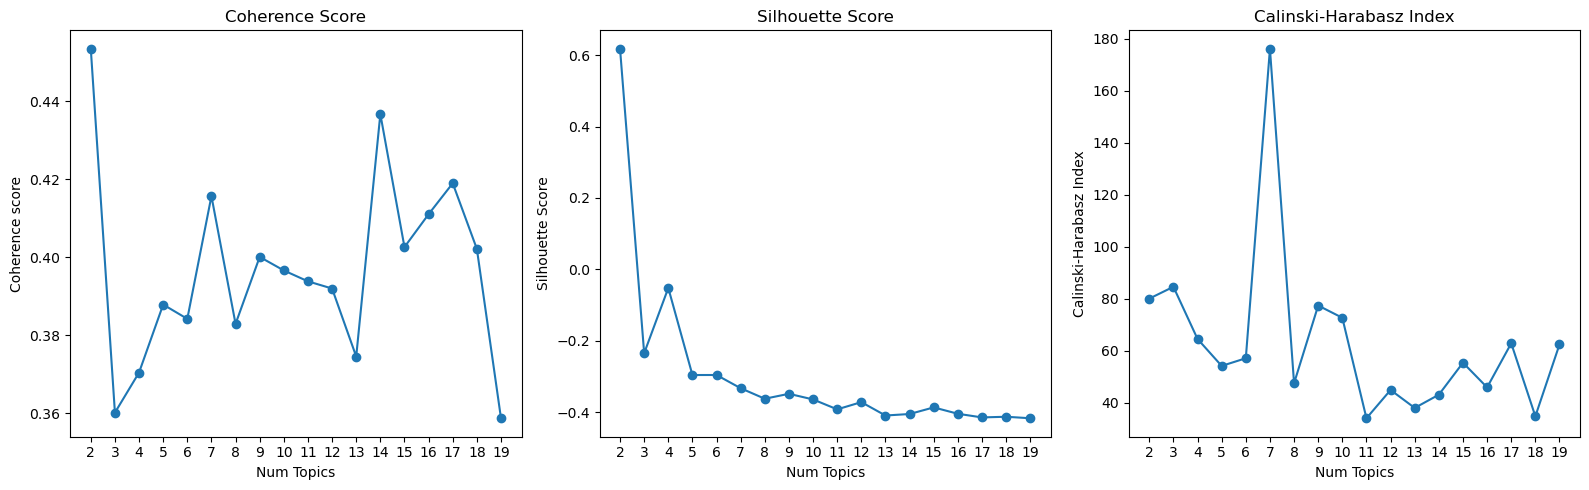

In [ ]:
plot_lsi_metrics(lemmas_list,dict_lemmas,corpus_lemmas)


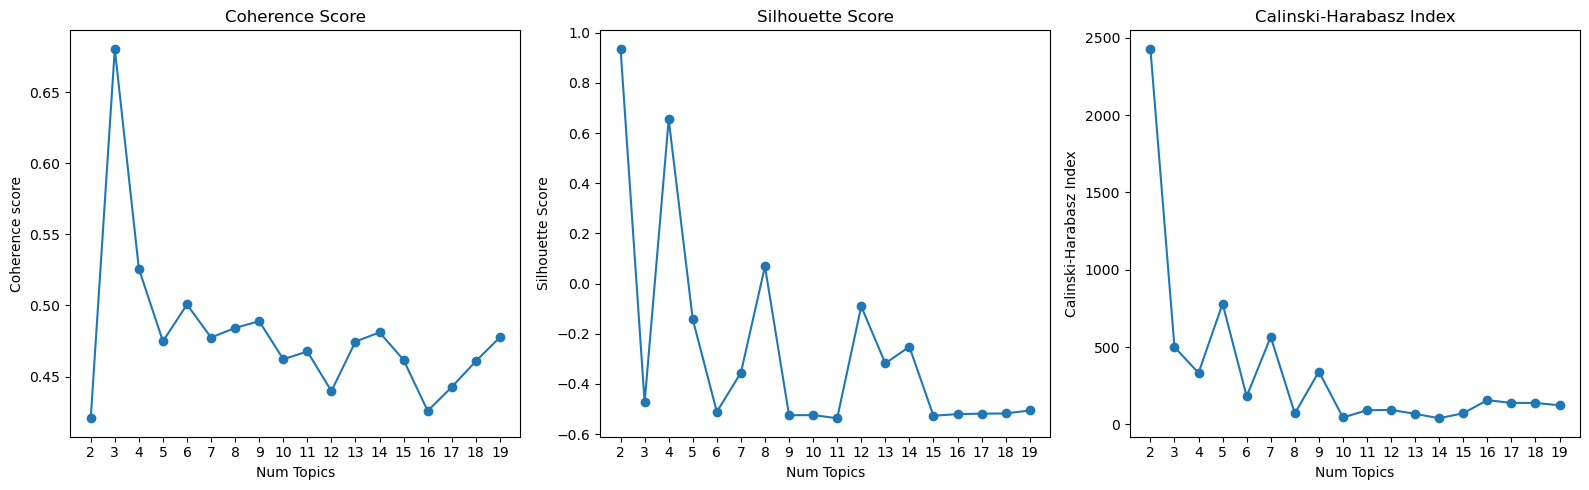

In [ ]:
plot_lsi_metrics(noun_chunks_list,dict_chunks,corpus_chunks)

## Evaluation

In [22]:
def evaluate_lsi(num_topics, corpus, dictionary):
    """
    Evaluate an LSI model by calculating coherence score, silhouette score, and Calinski-Harabasz score.

    Args:
    - num_topics: the number of topics in the LSI model
    - corpus: the corpus representation of the strings
    - dictionary: the dictionary of the strings

    Returns:
    - X_lsi: the LSI vectors of the input strings
    - labels_lsi: the cluster labels assigned to each data point based on LSI

    """
    lsi_model = LsiModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics)
    doc_topic_matrix = lsi_model[corpus] 
    X_lsi = gensim.matutils.corpus2dense(doc_topic_matrix, num_terms=num_topics).T
    major_topic = [np.argmax(arr) for arr in X_lsi]
    labels_lsi = major_topic
    coherence_model_lsi = gensim.models.CoherenceModel(model=lsi_model, texts=lemmas_list, dictionary=dictionary, coherence='c_v')
    coherence_lsi = coherence_model_lsi.get_coherence()
    print(f"Coherence score: {coherence_lsi}")
    print('Silhouette Score: {}'.format(silhouette_score(X_lsi, labels_lsi)))
    print('Calinski Harabasz Score: {}'.format(calinski_harabasz_score(X_lsi, labels_lsi)))
    return X_lsi, labels_lsi


In [23]:
X_lsi_lemmas,labels_lsi_lemmas = evaluate_lsi(7,corpus_lemmas,dict_lemmas)

Coherence score: 0.33098458048096774
Silhouette Score: -0.31625041365623474
Calinski Harabasz Score: 56.8852800336904


In [24]:
X_lsi_chunks,labels_lsi_chunks = evaluate_lsi(4,corpus_chunks,dict_chunks)

Coherence score: nan
Silhouette Score: -0.23966020345687866
Calinski Harabasz Score: 1078.897759836973


In [ ]:
save_clustering_results(df_main, labels_lsi_lemmas, 'lsi7.csv')
save_clustering_results(df_main, labels_lsi_chunks, 'lsi4_nouns.csv')

# TF-IDF + LSI

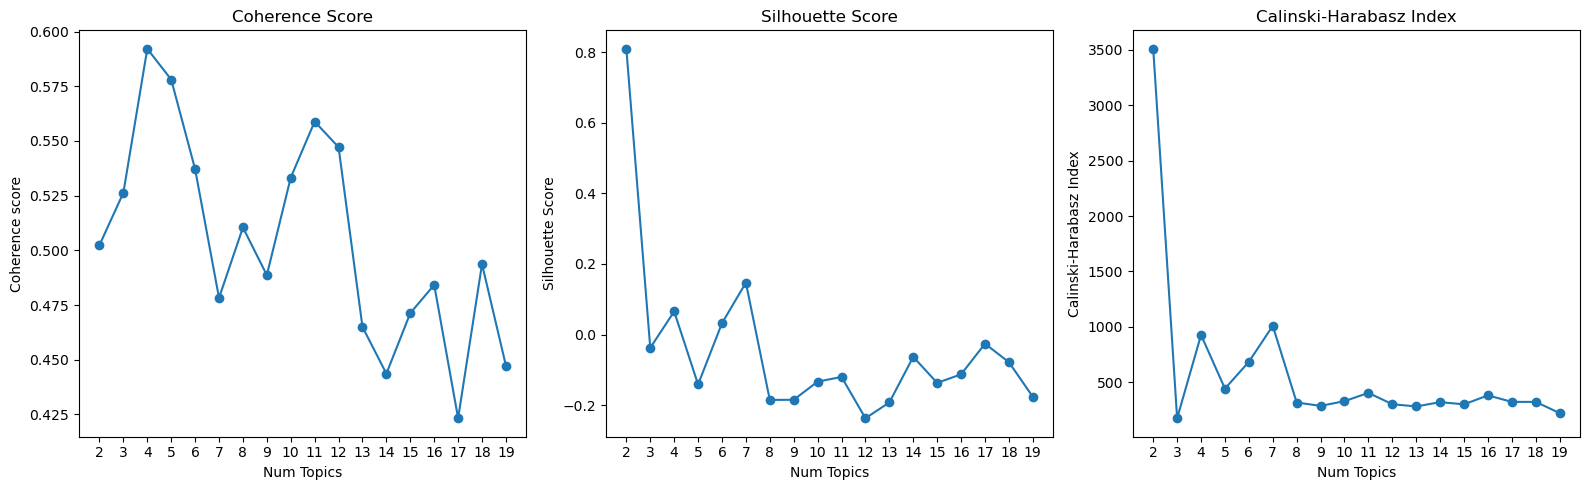

In [ ]:
plot_lsi_metrics(lemmas_list,dict_lemmas_tfidf,corpus_lemmas_tfidf)

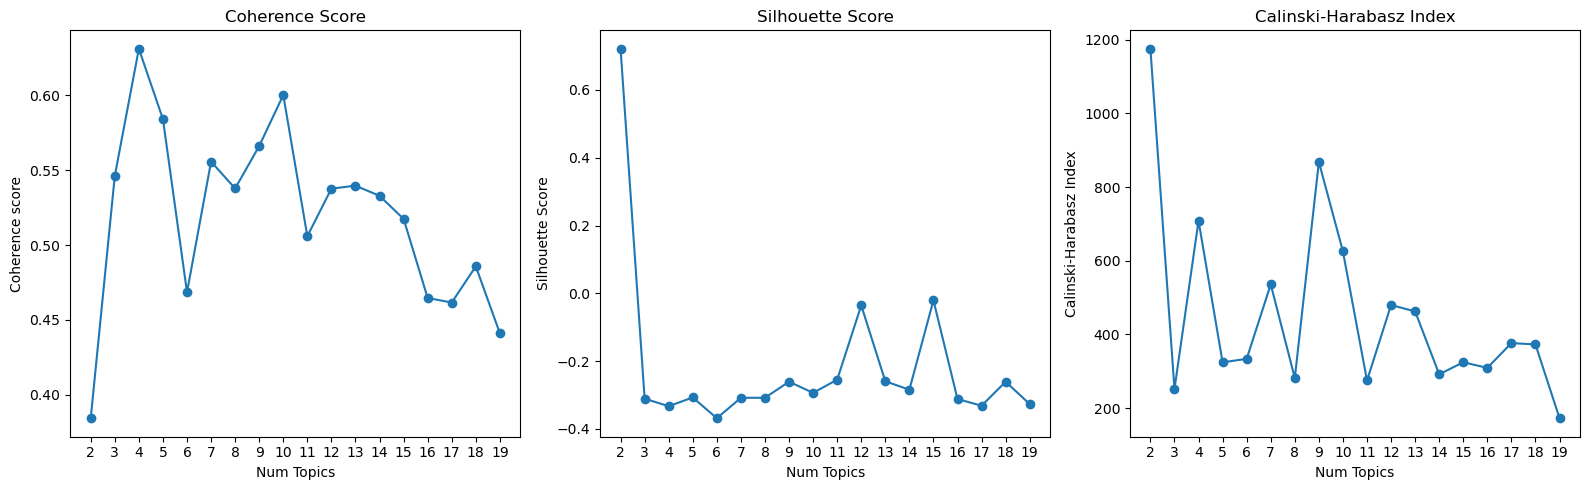

In [ ]:
plot_lsi_metrics(noun_chunks_list,dict_chunks_tfidf,corpus_chunks_tfidf)

## Evaluation

In [25]:
X_lsi_tfidf_lemmas,labels_lsi_lemmas_tfidf = evaluate_lsi(4,corpus_lemmas_tfidf,dict_lemmas_tfidf)

Coherence score: 0.7764228526413761
Silhouette Score: 0.08800685405731201
Calinski Harabasz Score: 1261.4206762497129


In [26]:
X_lsi_tfidf_chunks,labels_lsi_chunks_tfidf = evaluate_lsi(4,corpus_chunks_tfidf,dict_chunks_tfidf)

Coherence score: nan
Silhouette Score: -0.29356247186660767
Calinski Harabasz Score: 393.00542835541825


In [ ]:
save_clustering_results(df_main, labels_lsi_lemmas_tfidf, 'lsitfidf4.csv')
save_clustering_results(df_main, labels_lsi_chunks_tfidf, 'lsitfidf4_nouns.csv')

# GSDMM

## Noun-Chunks

In [27]:
def top_words(mgp, top_cluster, values):
    """
    Print the top words for each cluster in the given top_cluster list.

    Args:
    - mgp: the Mixture Gaussian Process model
    - top_cluster: a list of cluster indices to consider
    - values: the number of top words to display for each cluster
    """
    for cluster in top_cluster:
        sort_dicts = sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))


In stage 0: transferred 5716 clusters with 2 clusters populated
In stage 1: transferred 2356 clusters with 2 clusters populated
In stage 2: transferred 806 clusters with 2 clusters populated
In stage 3: transferred 541 clusters with 2 clusters populated
In stage 4: transferred 462 clusters with 2 clusters populated
In stage 5: transferred 410 clusters with 2 clusters populated
In stage 6: transferred 393 clusters with 2 clusters populated
In stage 7: transferred 408 clusters with 2 clusters populated
In stage 8: transferred 421 clusters with 2 clusters populated
In stage 9: transferred 397 clusters with 2 clusters populated
In stage 10: transferred 408 clusters with 2 clusters populated
In stage 11: transferred 408 clusters with 2 clusters populated
In stage 12: transferred 419 clusters with 2 clusters populated
In stage 13: transferred 420 clusters with 2 clusters populated
In stage 14: transferred 395 clusters with 2 clusters populated
In stage 15: transferred 384 clusters with 2 clu

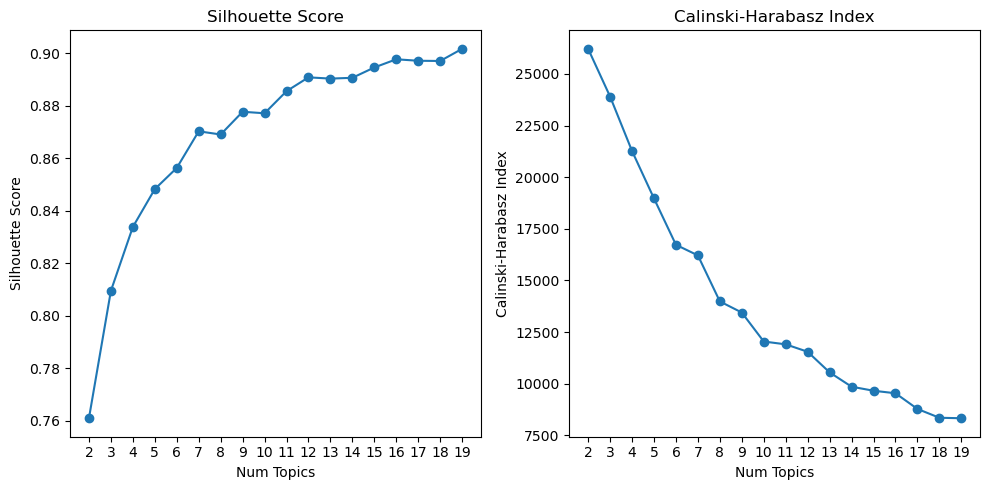

In [ ]:
# Check silhouette score and Calinski-Harabasz index for different number of topics for GSDMM
coherence_values = []
silhouette_scores = []
ch_indexes = []
model_list = []
vocab = set(x for chunk_set in noun_chunks_list for x in chunk_set)
n_terms = len(vocab)
iters = range(2,20)
for num_topics in iters:
    mgp = MovieGroupProcess(K=num_topics, alpha=0.01, beta=0.01, n_iters=20)
    model = mgp.fit(noun_chunks_list, n_terms)
    X_gssdmm = []
    for lemma in noun_chunks_list:
        doc_probabilities = mgp.score(lemma)
        X_gssdmm.append(doc_probabilities)
    X_gssdmm = np.array(X_gssdmm)
    silhouette_scores.append(silhouette_score(X_gssdmm, model))
    ch_indexes.append(calinski_harabasz_score(X_gssdmm, model))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(iters, silhouette_scores, marker='o')
axs[0].set_xlabel("Num Topics")
axs[0].set_ylabel("Silhouette Score")
axs[0].set_title("Silhouette Score")
axs[0].set_xticks(list(range(2,20)))

axs[1].plot(iters, ch_indexes, marker='o')
axs[1].set_xlabel("Num Topics")
axs[1].set_ylabel("Calinski-Harabasz Index")
axs[1].set_title("Calinski-Harabasz Index")
axs[1].set_xticks(list(range(2,20)))

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_gsdmm(mgp, str_list):
    """
    Evaluate a GSDMM model by printing the number of documents per topic, the most important clusters,
    and the top words for each cluster.

    Args:
    - mgp: the Mixture Gaussian Process model
    - str_list: the nested list of string

    Returns:
    - X_gssdmm: the GSDMM vectors of the input strings

    """
    doc_count = np.array(mgp.cluster_doc_count)
    print('Number of documents per topic:', doc_count)
    top_index = doc_count.argsort()[-10:][::-1]
    print('\nMost important clusters (by number of docs inside):', top_index)
    top_words(mgp, top_index, 10)
    X_gssdmm = []
    for sentence in str_list:
        doc_probabilities = mgp.score(sentence)
        X_gssdmm.append(doc_probabilities)
    X_gssdmm = np.array(X_gssdmm)
    return X_gssdmm

In [ ]:
mgp_7 = MovieGroupProcess(K=7, alpha=0.01, beta=0.01, n_iters=30)
labels_gssdmm_chunks = mgp_7.fit(lemmas_list, n_terms)

In stage 0: transferred 9677 clusters with 7 clusters populated
In stage 1: transferred 4199 clusters with 7 clusters populated
In stage 2: transferred 2537 clusters with 7 clusters populated
In stage 3: transferred 1831 clusters with 7 clusters populated
In stage 4: transferred 1414 clusters with 7 clusters populated
In stage 5: transferred 1168 clusters with 7 clusters populated
In stage 6: transferred 1024 clusters with 7 clusters populated
In stage 7: transferred 965 clusters with 7 clusters populated
In stage 8: transferred 891 clusters with 7 clusters populated
In stage 9: transferred 842 clusters with 7 clusters populated
In stage 10: transferred 855 clusters with 7 clusters populated
In stage 11: transferred 839 clusters with 7 clusters populated
In stage 12: transferred 798 clusters with 7 clusters populated
In stage 13: transferred 777 clusters with 7 clusters populated
In stage 14: transferred 757 clusters with 7 clusters populated
In stage 15: transferred 767 clusters with 

In [ ]:
X_gssdmm_chunks = evaluate_gsdmm(mgp_7,noun_chunks_list)

Number of documents per topic : [1393 1296  951 1028 1766 1057 4509]

Most important clusters (by number of docs inside): [6 4 0 1 5 3 2]

Cluster 6 : [('people', 3528), ('_', 1929), ('-', 1782), ('America', 1711), ('Russia', 1480), ('Israel', 1382), ('Obama', 1178), ('time', 1167), ('fact', 1166), ('Syria', 1115)]

Cluster 4 : [('Trump', 676), ('Obama', 457), ('people', 445), ('Congress', 343), ('Republicans', 286), ('America', 282), ('Donald Trump', 270), ('Democrats', 223), ('Clinton', 221), ('Hillary Clinton', 213)]

Cluster 0 : [('Russia', 540), ('Syria', 497), ('Israel', 335), ('people', 320), ('Iran', 301), ('Iraq', 257), ('Europe', 239), ('China', 225), ('Britain', 219), ('ISIS', 180)]

Cluster 1 : [('people', 450), ('life', 154), ('time', 144), ('things', 139), ('News', 133), ('police', 113), ('-', 87), ('fact', 81), ('place', 74), ('order', 70)]

Cluster 5 : [('people', 223), ('God', 172), ('women', 138), ('-', 92), ('time', 91), ('life', 70), ('Advertisements', 70), ('things

In [ ]:
save_clustering_results(df_main, labels_gssdmm_chunks, 'gssdmm7_nouns.csv')

## Lemmas

In [ ]:
mgp_20 = MovieGroupProcess(K=20, alpha=0.01, beta=0.01, n_iters=30)
model_20 = mgp_20.fit(lemmas_list, n_terms)

In stage 0: transferred 11385 clusters with 20 clusters populated
In stage 1: transferred 1405 clusters with 20 clusters populated
In stage 2: transferred 145 clusters with 15 clusters populated
In stage 3: transferred 34 clusters with 15 clusters populated
In stage 4: transferred 11 clusters with 15 clusters populated
In stage 5: transferred 10 clusters with 14 clusters populated
In stage 6: transferred 7 clusters with 14 clusters populated
In stage 7: transferred 8 clusters with 14 clusters populated
In stage 8: transferred 11 clusters with 14 clusters populated
In stage 9: transferred 6 clusters with 15 clusters populated
In stage 10: transferred 12 clusters with 14 clusters populated
In stage 11: transferred 11 clusters with 14 clusters populated
In stage 12: transferred 10 clusters with 14 clusters populated
In stage 13: transferred 11 clusters with 14 clusters populated
In stage 14: transferred 13 clusters with 14 clusters populated
In stage 15: transferred 7 clusters with 15 clu

In [ ]:
_ = evaluate_gsdmm(mgp_20,lemmas_list)

Number of documents per topic : [  176    12     6    12    10   148     0    74    12    10     0    28
     0     0    32     0     0    10     6 23464]

Most important clusters (by number of docs inside): [19  0  5  7 14 11  8  1  3  4]

Cluster 19 : [('say', 42364), ('people', 27012), ('year', 24850), ('time', 22872), ('like', 21112), ('know', 19214), ('state', 17406), ('come', 16490), ('go', 15544), ('government', 14700)]

Cluster 0 : [('season', 72), ('Manchester', 70), ('United', 66), ('League', 64), ('say', 56), ('Chelsea', 54), ('old', 52), ('club', 52), ('Arsenal', 52), ('Premier', 50)]

Cluster 5 : [('family', 76), ('love', 66), ('beloved', 66), ('wife', 58), ('NY', 54), ('friend', 54), ('New', 48), ('service', 46), ('mother', 44), ('year', 36)]

Cluster 7 : [('image', 148), ('BBcode', 148), ('line', 74), ('use', 74), ('highlight', 74), ('copy', 74), ('easy', 74), ('rating', 74), ('rate', 74), ('code', 74)]

Cluster 14 : [('share', 50), ('Sheeple', 50), ('report', 28), ('Dai

In [ ]:
mgp_4 = MovieGroupProcess(K=4, alpha=0.01, beta=0.01, n_iters=30)
labels_gssdmm_lemmas= mgp_4.fit(lemmas_list, n_terms)

In stage 0: transferred 9087 clusters with 4 clusters populated
In stage 1: transferred 1265 clusters with 4 clusters populated
In stage 2: transferred 198 clusters with 4 clusters populated
In stage 3: transferred 33 clusters with 4 clusters populated
In stage 4: transferred 22 clusters with 4 clusters populated
In stage 5: transferred 10 clusters with 4 clusters populated
In stage 6: transferred 11 clusters with 4 clusters populated
In stage 7: transferred 10 clusters with 4 clusters populated
In stage 8: transferred 9 clusters with 4 clusters populated
In stage 9: transferred 9 clusters with 4 clusters populated
In stage 10: transferred 9 clusters with 4 clusters populated
In stage 11: transferred 5 clusters with 4 clusters populated
In stage 12: transferred 5 clusters with 4 clusters populated
In stage 13: transferred 10 clusters with 4 clusters populated
In stage 14: transferred 10 clusters with 4 clusters populated
In stage 15: transferred 12 clusters with 4 clusters populated
In

In [ ]:
X_gssdmm_lemmas = evaluate_gsdmm(mgp_4,lemmas_list)

Number of documents per topic : [  127    75    54 11744]

Most important clusters (by number of docs inside): [3 0 1 2]

Cluster 3 : [('say', 21188), ('people', 13506), ('year', 12422), ('time', 11438), ('like', 10558), ('know', 9606), ('state', 8704), ('come', 8245), ('go', 7773), ('government', 7350)]

Cluster 0 : [('talk', 69), ('share', 33), ('season', 33), ('League', 32), ('Manchester', 32), ('United', 31), ('report', 29), ('link', 29), ('old', 26), ('think', 26)]

Cluster 1 : [('family', 38), ('love', 33), ('beloved', 33), ('wife', 29), ('NY', 27), ('friend', 27), ('service', 23), ('New', 23), ('mother', 22), ('year', 18)]

Cluster 2 : [('image', 74), ('BBcode', 74), ('page', 50), ('view', 48), ('property', 39), ('line', 37), ('People', 37), ('rate', 37), ('use', 37), ('upload', 37)]


In [ ]:
save_clustering_results(df_main, labels_gssdmm_lemmas, 'gssdmm4.csv')

# Comparison of clustering results

In [ ]:
clustering_algorithms = ['TF-IDF + K-Means', 'Doc2Vec + K-Means', 'LDA', 'TF-IDF + LDA', 'LSI', 'TF-IDF + LSI ', 'GSSDMM']
X_methods_lemmas = [X_tfidf_lemmas.toarray(), X_doc2vec_lemmas, X_lda_lemmas, X_lda_tfidf_lemmas, X_lsi_lemmas, X_lsi_tfidf_lemmas, X_gssdmm_lemmas]
l_methods_lemmas = [labels_tf_idf_lemmas, labels_doc2vec_lemmas, labels_lda_lemmas, labels_lda_lemmas_tfidf, labels_lsi_lemmas, labels_lsi_lemmas_tfidf, labels_gssdmm_lemmas]
silhouette_scores = [silhouette_score(X, labels) for X, labels in zip(X_methods_lemmas, l_methods_lemmas)]
calinski_harabasz_scores = [calinski_harabasz_score(X, labels) for X, labels in zip(X_methods_lemmas, l_methods_lemmas)]
df_comparison_lemmas = pd.DataFrame({'Clustering Algorithm': clustering_algorithms, 'Silhouette Score': silhouette_scores, 'Calinski-Harabasz Score': calinski_harabasz_scores})

print(df_comparison_lemmas)

  Clustering Algorithm  Silhouette Score  Calinski-Harabasz Score
0     TF-IDF + K-Means          0.037988               293.862914
1    Doc2Vec + K-Means          0.133619               449.620750
2                  LDA          0.607199             18668.826789
3         TF-IDF + LDA          0.872787             91490.691044
4                  LSI         -0.319640                49.491518
5        TF-IDF + LSI           0.468400              1655.872939
6               GSSDMM          0.714127               529.411002


In [ ]:
X_methods_chunks = [X_tfidf_chunks.toarray(), X_doc2vec_chunks, X_lda_chunks, X_lda_tfidf_chunks, X_lsi_chunks, X_lsi_tfidf_chunks, X_gssdmm_chunks]
l_methods_chunks = [labels_tf_idf_chunks, labels_doc2vec_chunks, labels_lda_chunks, labels_lda_chunks_tfidf, labels_lsi_chunks, labels_lsi_chunks_tfidf, labels_gssdmm_chunks]
silhouette_scores = [silhouette_score(X, labels) for X, labels in zip(X_methods_chunks, l_methods_chunks)]
calinski_harabasz_scores = [calinski_harabasz_score(X, labels) for X, labels in zip(X_methods_chunks, l_methods_chunks)]
df_comparison_chunks = pd.DataFrame({'Clustering Algorithm': clustering_algorithms, 'Silhouette Score': silhouette_scores, 'Calinski-Harabasz Score': calinski_harabasz_scores})

print(df_comparison_chunks)

  Clustering Algorithm  Silhouette Score  Calinski-Harabasz Score
0     TF-IDF + K-Means          0.067379               314.091420
1    Doc2Vec + K-Means          0.386183              3473.236819
2                  LDA          0.883480            110432.096229
3         TF-IDF + LDA          0.929051            323993.322122
4                  LSI         -0.512264               131.990866
5        TF-IDF + LSI          -0.289569               393.538173
6               GSSDMM          0.866992             15681.389272


In [49]:
def plot_countplots(labels,algorithms):
    """
    Plot the distribution of clusters for each clustering algorithm.

    Args:
    - labels: the cluster labels assigned to each data point
    - algorithms: the names of the clustering algorithms

    Returns:
    - fig: the plotnine figure
    
    """
    plots = []
    load = []
    for i, label in enumerate(labels):
        count_df = pd.DataFrame({'label': label})
        count_df = count_df['label'].value_counts().reset_index()
        count_df.columns = ['label', 'count']
        p = (ggplot(count_df, aes(x='label', y='count')) + 
            geom_col(color = 'darkblue', fill = 'lightblue') +
            theme_minimal() +
            labs(title='Cluster Distribution for '+str(algorithms[i]), y='Count', x='Clusters'))
        plots.append(p)
        load.append(pw.load_ggplot(p, figsize=(3, 3)))
    empty1 = pw.load_ggplot((ggplot() +  theme_void()), figsize=(5, 5))
    fig = (load[0] | load[1] | load[2] | load[3] ) / ( load[4] | load[5] | load[6] | empty1)
    fig.savefig('countplots.png')
    return fig

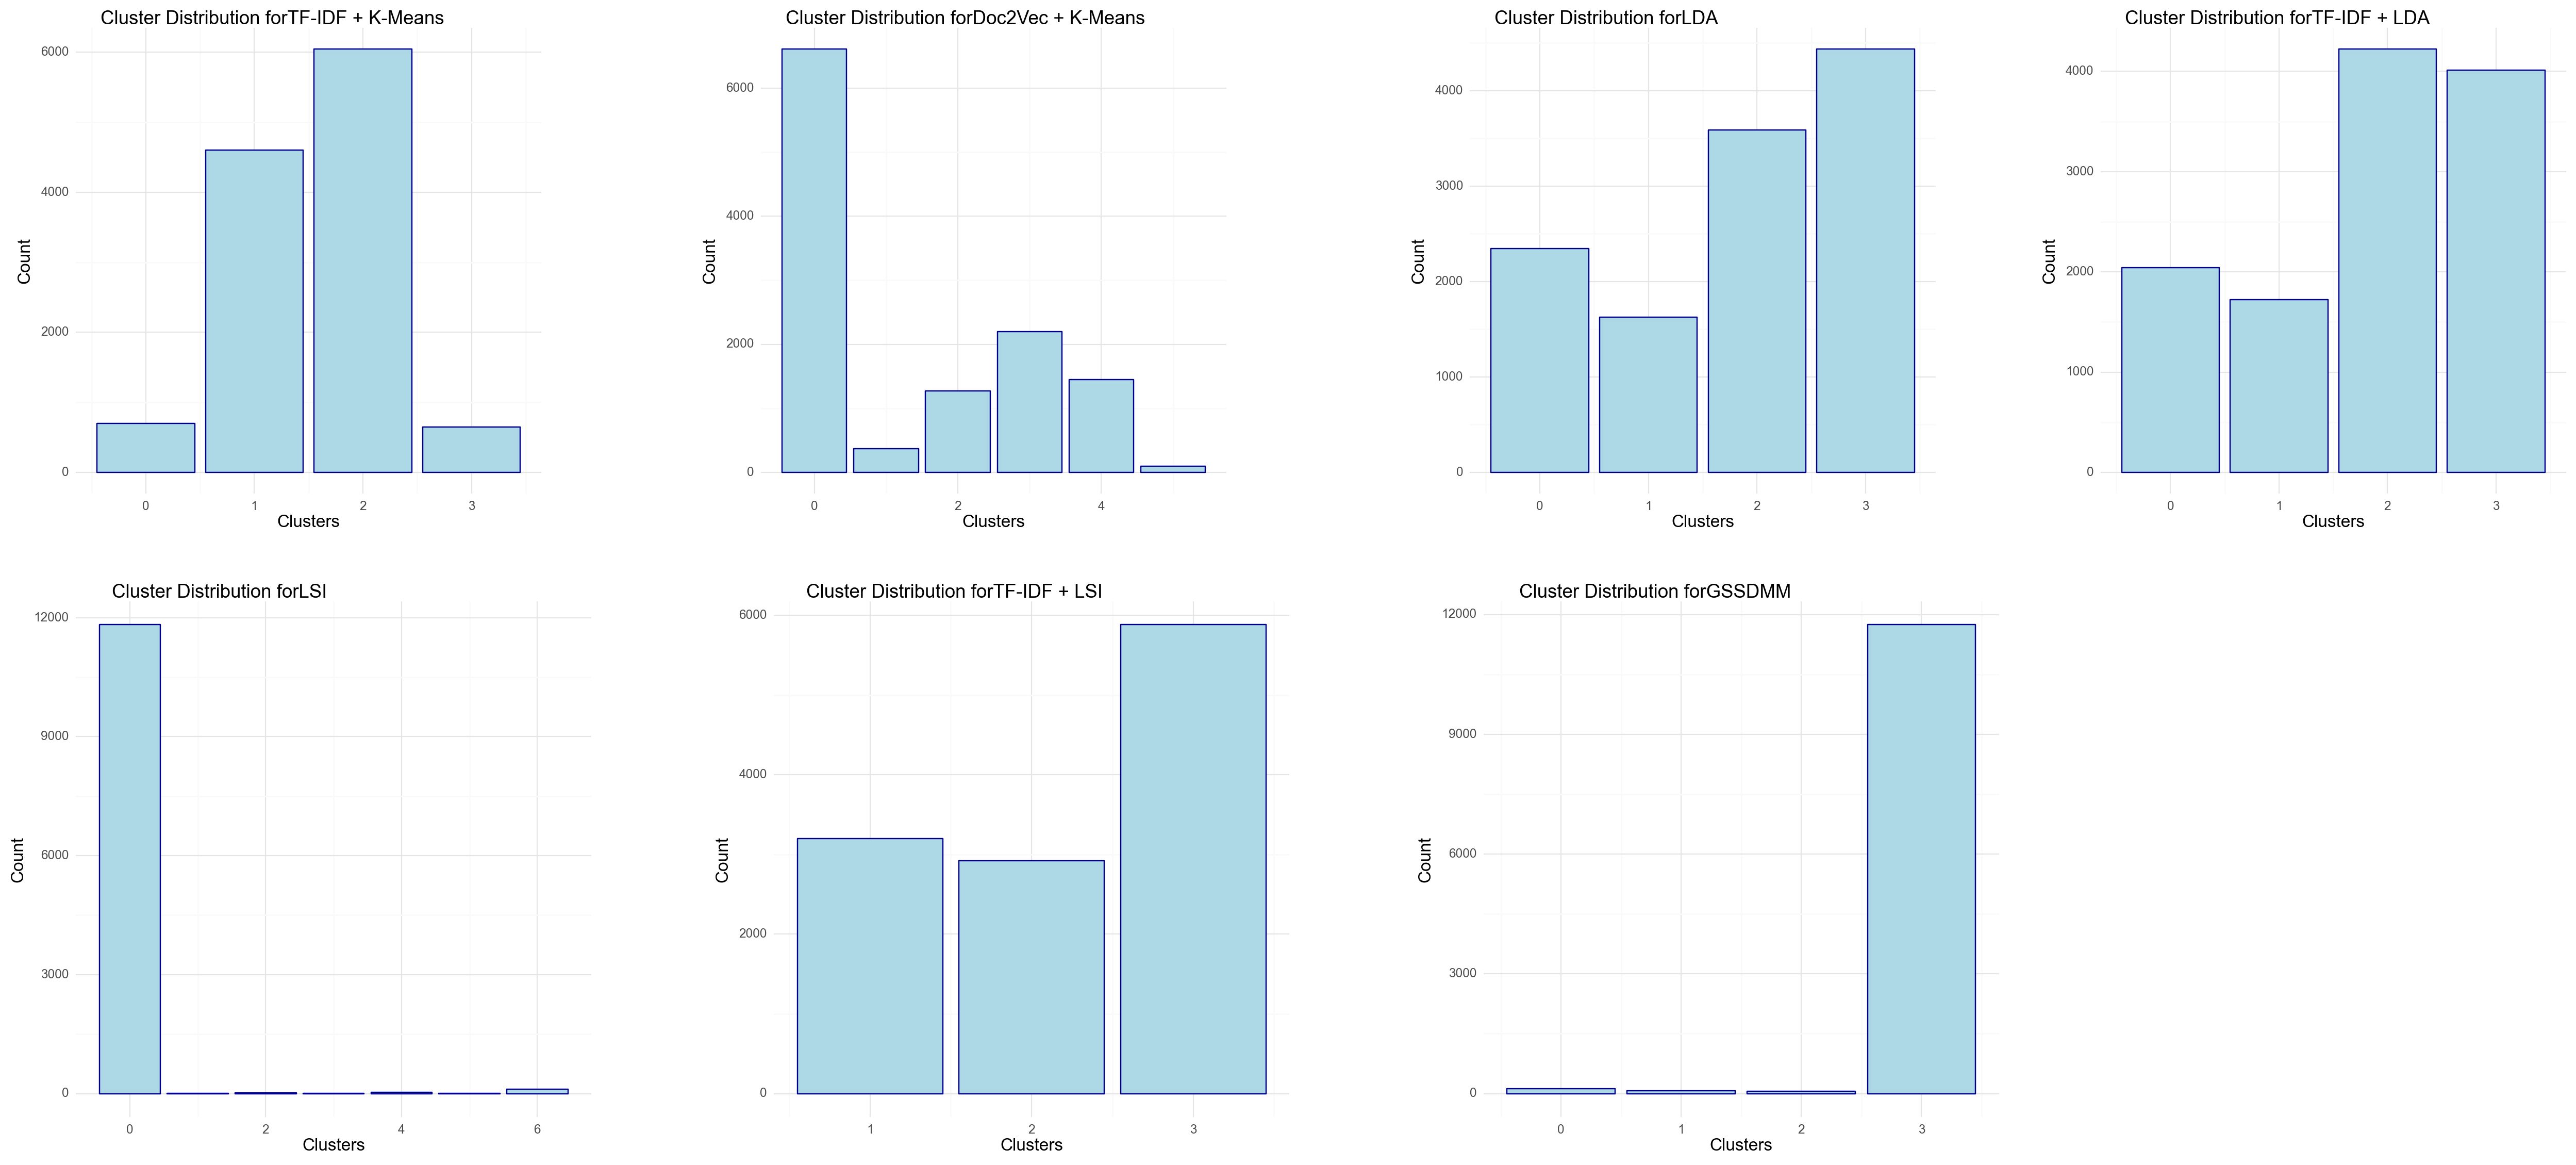

In [47]:
plot_countplots(l_methods_lemmas,clustering_algorithms)

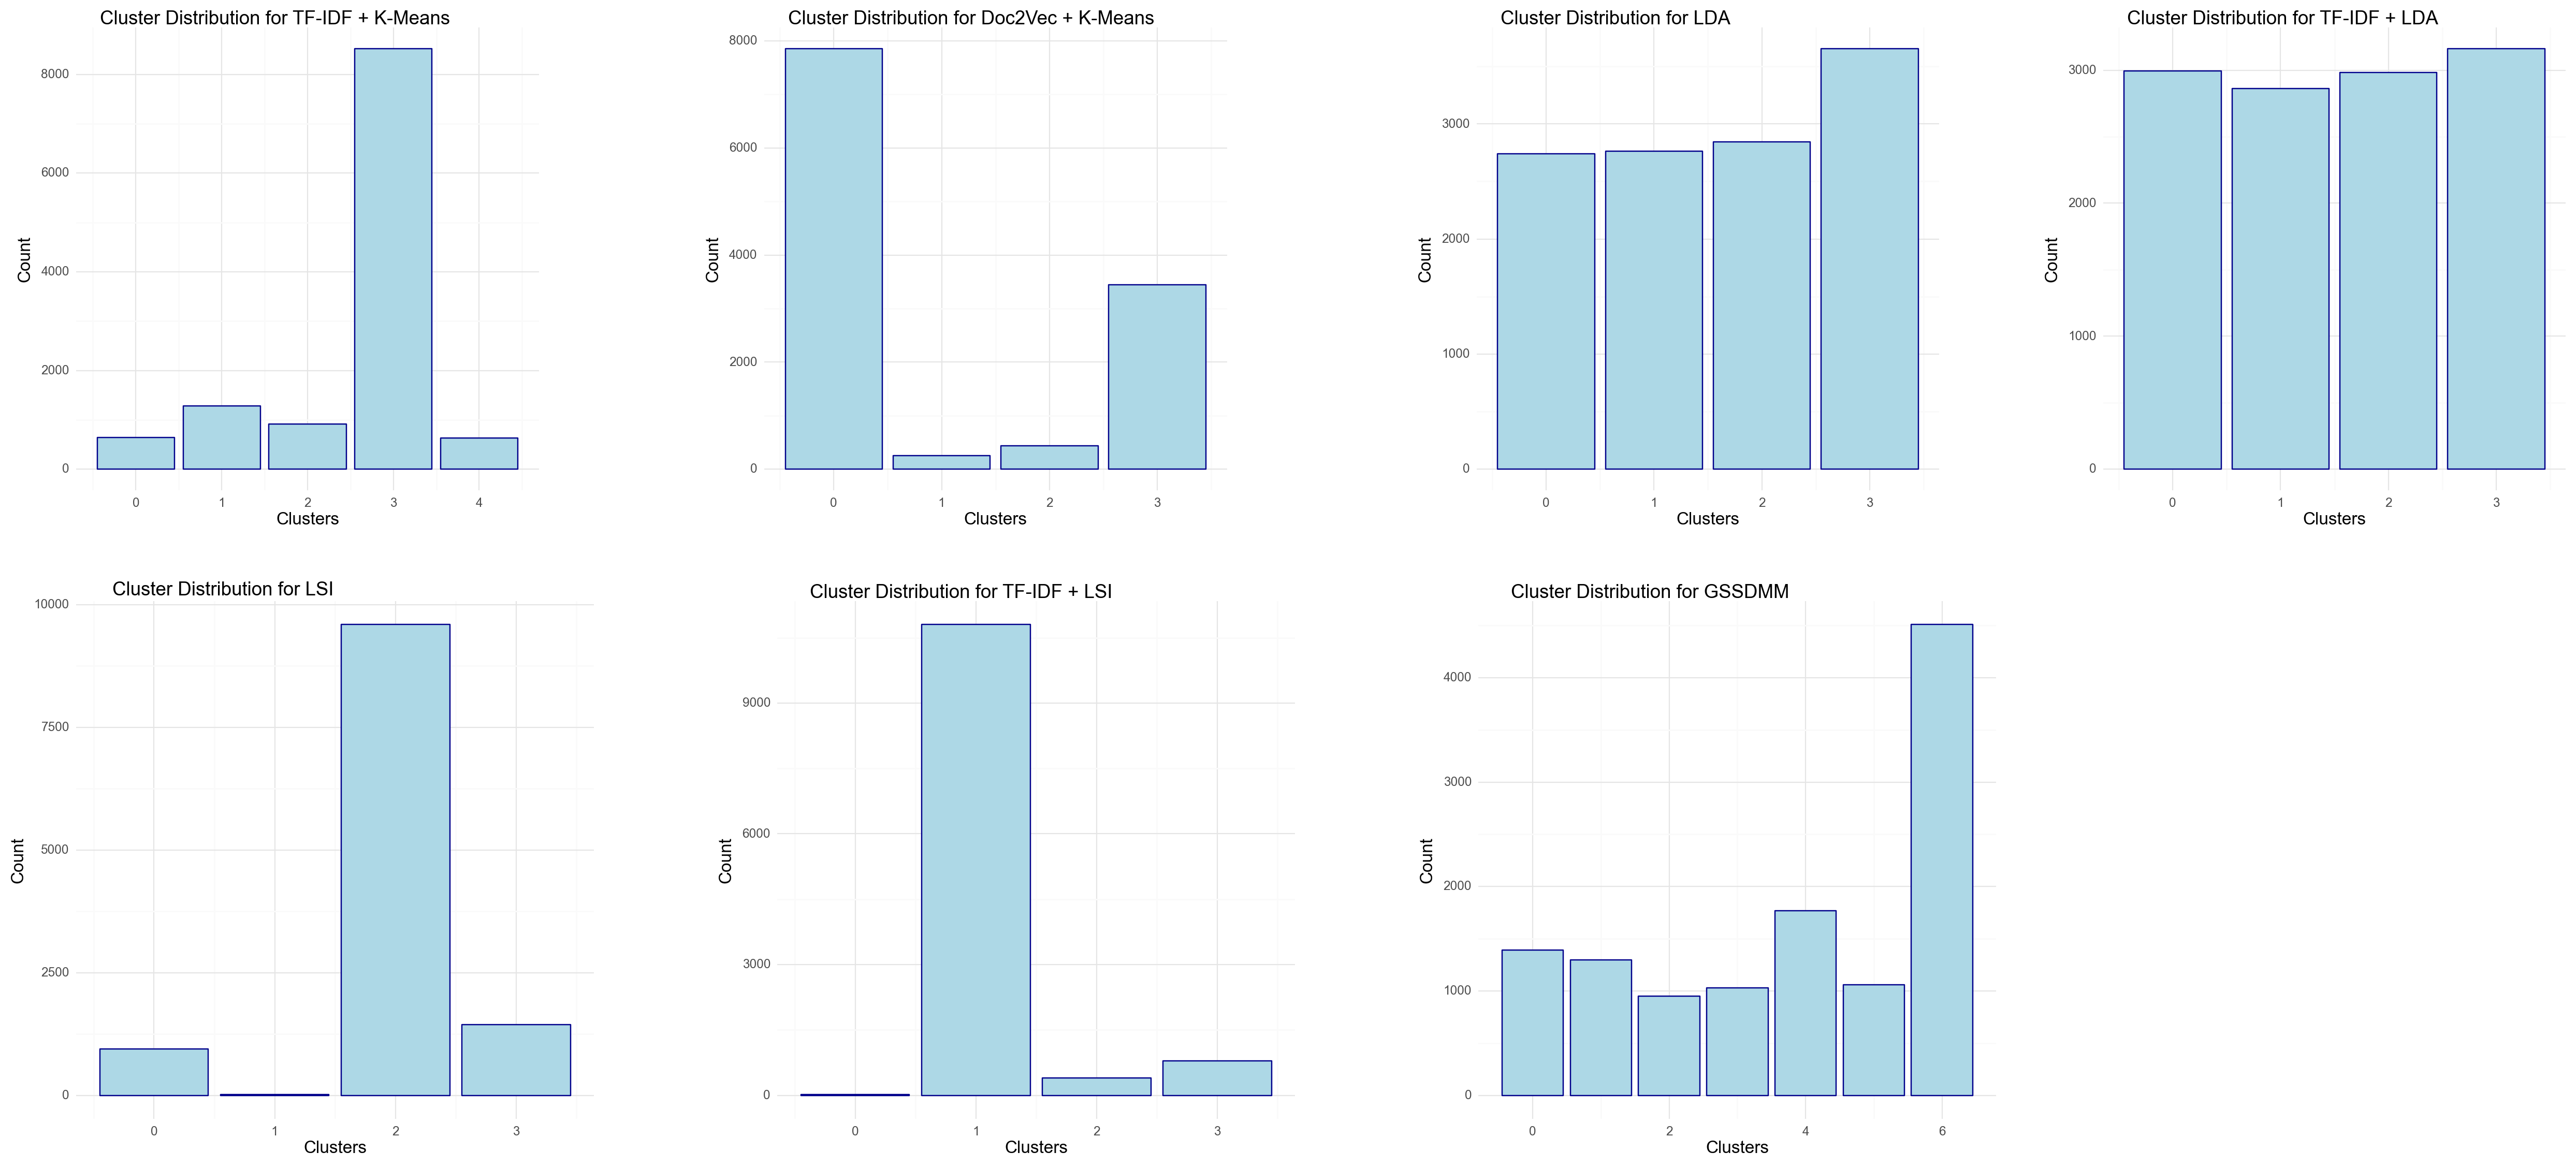

In [50]:
plot_countplots(l_methods_chunks,clustering_algorithms)

Lookng into two best clustering results - for TF-IDF + LDA on noun-chunks with 4 clusters and GSSDMM on noun-chunks with 7 clusters.

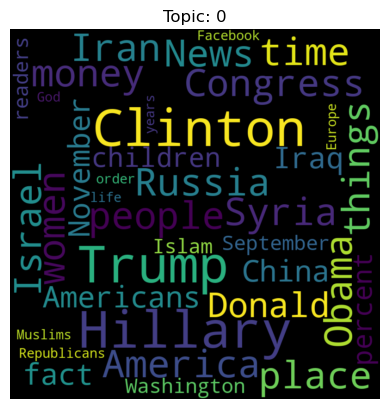

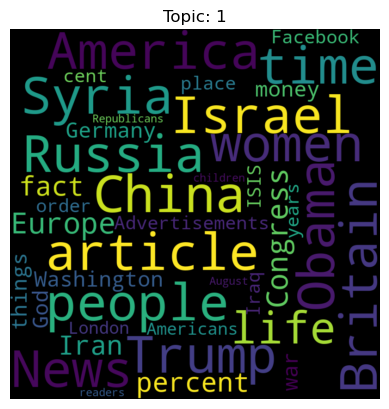

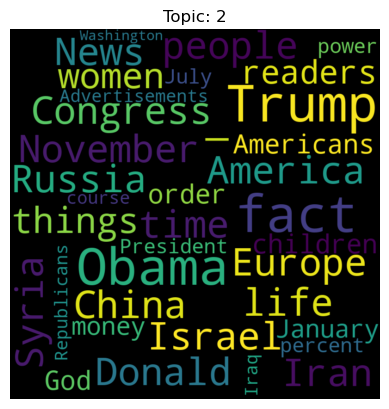

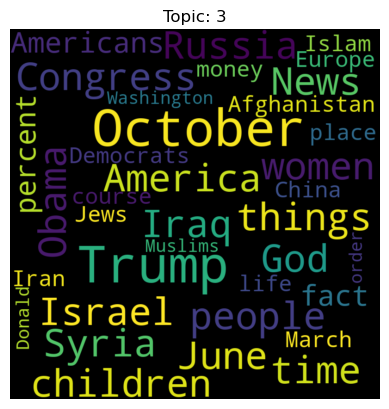

In [ ]:
lda_tfidf_model = LdaMulticore(corpus=corpus_chunks_tfidf,
                     id2word=dict_chunks_tfidf,
                     num_topics=4,
                     random_state=42)
for topic_id, topic in enumerate(lda_tfidf_model.print_topics(num_topics=4, num_words=40)):
    topic_words = " ".join([word.split("*")[1].strip() for word in topic[1].split(" + ")])
    wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110).generate(topic_words)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic: {}".format(topic_id))
    plt.show()

In [ ]:
_ = evaluate_gsdmm(mgp_7,noun_chunks_list)

Number of documents per topic : [1393 1296  951 1028 1766 1057 4509]

Most important clusters (by number of docs inside): [6 4 0 1 5 3 2]

Cluster 6 : [('people', 3528), ('_', 1929), ('-', 1782), ('America', 1711), ('Russia', 1480), ('Israel', 1382), ('Obama', 1178), ('time', 1167), ('fact', 1166), ('Syria', 1115)]

Cluster 4 : [('Trump', 676), ('Obama', 457), ('people', 445), ('Congress', 343), ('Republicans', 286), ('America', 282), ('Donald Trump', 270), ('Democrats', 223), ('Clinton', 221), ('Hillary Clinton', 213)]

Cluster 0 : [('Russia', 540), ('Syria', 497), ('Israel', 335), ('people', 320), ('Iran', 301), ('Iraq', 257), ('Europe', 239), ('China', 225), ('Britain', 219), ('ISIS', 180)]

Cluster 1 : [('people', 450), ('life', 154), ('time', 144), ('things', 139), ('News', 133), ('police', 113), ('-', 87), ('fact', 81), ('place', 74), ('order', 70)]

Cluster 5 : [('people', 223), ('God', 172), ('women', 138), ('-', 92), ('time', 91), ('life', 70), ('Advertisements', 70), ('things